In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_009"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [6]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [7]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, Resize(size, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.5, 
                             pad_mode=PadMode.Zeros)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing(p=0.75))
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

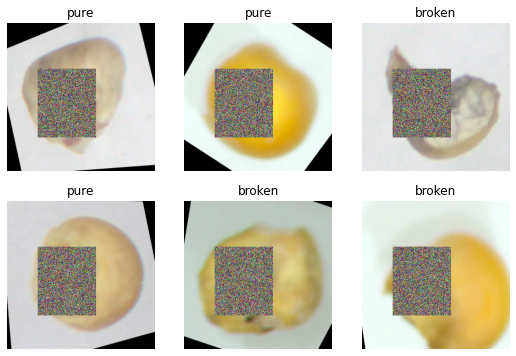

In [8]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [9]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [13]:
# set_seed(42);set_fast_norm()

# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
                           
#     dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
#     learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
#                            loss_func=FocalLossFlat(), metrics=[accuracy], 
#                            splitter=partial(timm_split, cut=-3)).to_fp16()
    
#     print(learn.lr_find(suggest_funcs=(valley, slide)))

In [15]:
n_epo = 10; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augsV2_focal_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_009_convnext_tiny_256_bs32_epo10_augsV2_focal_ft


In [17]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            #wandb.define_metric('accuracy', hidden=False, summary="max")
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=FocalLossFlat(), metrics=[accuracy], 
                                   splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),WandbCallback(log_preds=None)]
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,0.830794,0.450206,0.676091,00:33


Better model found at epoch 0 with accuracy value: 0.6760907769203186.


epoch,train_loss,valid_loss,accuracy,time
0,0.491224,0.301875,0.742757,00:44
1,0.393505,0.328709,0.718674,00:44
2,0.325995,0.256540,0.763351,00:44
3,0.318828,0.270816,0.733333,00:44
4,0.281389,0.236341,0.772426,00:44
5,0.259932,0.225493,0.776963,00:44
6,0.243390,0.199662,0.793717,00:44
7,0.207334,0.211168,0.795462,00:44
8,0.201026,0.197435,0.801396,00:44
9,0.189607,0.195476,0.803490,00:44


Better model found at epoch 0 with accuracy value: 0.7427574396133423.
Better model found at epoch 2 with accuracy value: 0.763350784778595.
Better model found at epoch 4 with accuracy value: 0.7724258303642273.
Better model found at epoch 5 with accuracy value: 0.7769633531570435.
Better model found at epoch 6 with accuracy value: 0.7937172651290894.
Better model found at epoch 7 with accuracy value: 0.7954624891281128.
Better model found at epoch 8 with accuracy value: 0.8013961315155029.
Better model found at epoch 9 with accuracy value: 0.803490400314331.
CPU: 3/6/3974 MB | GPU: 284/2386/7409 MB | Time 0:08:22.984 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,0.810200,0.457235,0.661082,00:33


Better model found at epoch 0 with accuracy value: 0.6610820293426514.


epoch,train_loss,valid_loss,accuracy,time
0,0.450498,0.309112,0.731937,00:44
1,0.369659,0.271182,0.747644,00:44
2,0.344355,0.248005,0.765794,00:44
3,0.303811,0.291089,0.728098,00:44
4,0.275698,0.241312,0.781501,00:44
5,0.250020,0.220193,0.792670,00:44
6,0.244056,0.199016,0.803141,00:44
7,0.216445,0.195807,0.798953,00:44
8,0.215580,0.190316,0.809424,00:44
9,0.202891,0.189142,0.810122,00:44


Better model found at epoch 0 with accuracy value: 0.7319371700286865.
Better model found at epoch 1 with accuracy value: 0.7476440072059631.
Better model found at epoch 2 with accuracy value: 0.765794038772583.
Better model found at epoch 4 with accuracy value: 0.7815008759498596.
Better model found at epoch 5 with accuracy value: 0.7926701307296753.
Better model found at epoch 6 with accuracy value: 0.8031413555145264.
Better model found at epoch 8 with accuracy value: 0.809424102306366.
Better model found at epoch 9 with accuracy value: 0.8101221919059753.
CPU: 7/47/3981 MB | GPU: 306/2548/7715 MB | Time 0:08:13.847 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,0.823235,0.486855,0.645601,00:33


Better model found at epoch 0 with accuracy value: 0.6456005573272705.


epoch,train_loss,valid_loss,accuracy,time
0,0.448991,0.317475,0.731494,00:44
1,0.378416,0.295219,0.731494,00:44
2,0.332180,0.288235,0.737081,00:44
3,0.293594,0.271572,0.750698,00:44
4,0.270280,0.248232,0.763268,00:44
5,0.256732,0.246921,0.757682,00:44
6,0.247561,0.215709,0.783869,00:44
7,0.228226,0.206969,0.798533,00:44
8,0.210078,0.197047,0.801676,00:44
9,0.198759,0.197053,0.803073,00:44


Better model found at epoch 0 with accuracy value: 0.7314944267272949.
Better model found at epoch 2 with accuracy value: 0.737080991268158.
Better model found at epoch 3 with accuracy value: 0.7506983280181885.
Better model found at epoch 4 with accuracy value: 0.7632681727409363.
Better model found at epoch 6 with accuracy value: 0.7838687300682068.
Better model found at epoch 7 with accuracy value: 0.7985334992408752.
Better model found at epoch 8 with accuracy value: 0.8016759753227234.
Better model found at epoch 9 with accuracy value: 0.8030726313591003.
CPU: 6/49/3987 MB | GPU: -100/2502/7615 MB | Time 0:08:15.965 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,0.813782,0.497529,0.644902,00:33


Better model found at epoch 0 with accuracy value: 0.644902229309082.


epoch,train_loss,valid_loss,accuracy,time
0,0.444680,0.312302,0.729399,00:44
1,0.380283,0.285342,0.745112,00:44
2,0.333292,0.252372,0.757332,00:44
3,0.311101,0.222036,0.783869,00:44
4,0.272775,0.213382,0.783869,00:44
5,0.272385,0.239889,0.747905,00:44
6,0.244792,0.187591,0.803422,00:44
7,0.230833,0.185229,0.809707,00:44
8,0.199967,0.177520,0.813547,00:44
9,0.205678,0.179278,0.814246,00:44


Better model found at epoch 0 with accuracy value: 0.7293994426727295.
Better model found at epoch 1 with accuracy value: 0.7451117038726807.
Better model found at epoch 2 with accuracy value: 0.7573323845863342.
Better model found at epoch 3 with accuracy value: 0.7838687300682068.
Better model found at epoch 6 with accuracy value: 0.8034217953681946.
Better model found at epoch 7 with accuracy value: 0.8097066879272461.
Better model found at epoch 8 with accuracy value: 0.8135474920272827.
Better model found at epoch 9 with accuracy value: 0.8142458200454712.
CPU: 0/46/3988 MB | GPU: 224/2412/7839 MB | Time 0:08:15.664 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,0.776067,0.543009,0.608589,00:33


Better model found at epoch 0 with accuracy value: 0.6085894107818604.


epoch,train_loss,valid_loss,accuracy,time
0,0.473148,0.316550,0.722416,00:44
1,0.371692,0.308229,0.733589,00:44
2,0.338247,0.264916,0.762570,00:44
3,0.309575,0.224420,0.796089,00:44
4,0.286642,0.221924,0.780028,00:44
5,0.269159,0.209142,0.794344,00:44
6,0.238242,0.203806,0.796439,00:44
7,0.236961,0.195050,0.800978,00:44
8,0.210340,0.183828,0.816690,00:44
9,0.205370,0.182432,0.815293,00:44


Better model found at epoch 0 with accuracy value: 0.7224162220954895.
Better model found at epoch 1 with accuracy value: 0.7335894107818604.
Better model found at epoch 2 with accuracy value: 0.7625698447227478.
Better model found at epoch 3 with accuracy value: 0.7960894107818604.
Better model found at epoch 6 with accuracy value: 0.7964385747909546.
Better model found at epoch 7 with accuracy value: 0.8009776473045349.
Better model found at epoch 8 with accuracy value: 0.8166899681091309.
CPU: 0/47/3989 MB | GPU: -132/2370/7707 MB | Time 0:08:15.518 | (Consumed/Peaked/Used Total)


In [19]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=FocalLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # original dl with validation tfms
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        # dl with hflip
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        # dl with vflip tfms
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80593, 0.80942, 0.81145, 0.81844, 0.8132]
Avg: 0.81169
Std: 0.00415
